# This Notebook aims to analyse the eTraGo results with a focus on the gas sector

First findings:
- There is no storage expansion in the gas (CH4 + H2) sector. Already available CH4 storage capacities (7.34e+02 TWh) are only 61.1 % used (4.48e+02 TWh). The actual capacity band (maximum_current_energy_capacity - minimum_current_energy_capacity) used is only 1.68e+02 TWh meaning only 23 % of already available storage capacity is used.



TODO:
- wait for new results with new constrains and H2 feedin changes
- clear up gap between H2 generation and loads
- also work on Heat and AC?
- talk to FL about who analyzes what!
- Update Colors in plot.py
- make germany piechart map for generation of all major carriers (Heat, CH4, H2, AC)

In [167]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from etrago import Etrago
from etrago import tools
from etrago.tools.plot import coloring

In [228]:
# results from old optimization run; clustering folder is from other run and does not even represent the same number of clusters
colors = coloring
etrago = Etrago(csv_folder_name= "results_new")
network = etrago.network.copy()

INFO:pypsa.io:Imported network results_new has buses, carriers, generators, lines, links, loads, storage_units, stores
C:\ProgramData\mambaforge\envs\etrago\lib\site-packages\pypsa\io.py:648: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  df = importer.get_static(list_name)
INFO:pypsa.io:Imported network clustering has buses, lines, links


In [5]:
network.buses.carrier.value_counts()

AC                    300
dsm                   286
Li ion                286
rural_heat            286
H2_saltcavern          78
CH4                    45
H2_grid                32
central_heat           32
central_heat_store     32
Name: carrier, dtype: int64

In [169]:
network.links.carrier.value_counts()

industrial_gas_CHP               447
central_resistive_heater         398
central_gas_CHP                  375
power_to_H2                      330
H2_to_power                      330
dsm                              286
BEV charger                      286
rural_heat_pump                  286
central_heat_pump                283
CH4                              100
central_gas_CHP_heat              47
central_gas_boiler                41
CH4_to_H2                         32
H2_feedin                         32
H2_to_CH4                         32
central_heat_store_charger        32
central_heat_store_discharger     32
DC                                15
OCGT                              14
Name: carrier, dtype: int64

# CH4

<AxesSubplot:title={'center':'CH4 Generation'}, xlabel='snapshot', ylabel='[GW]'>

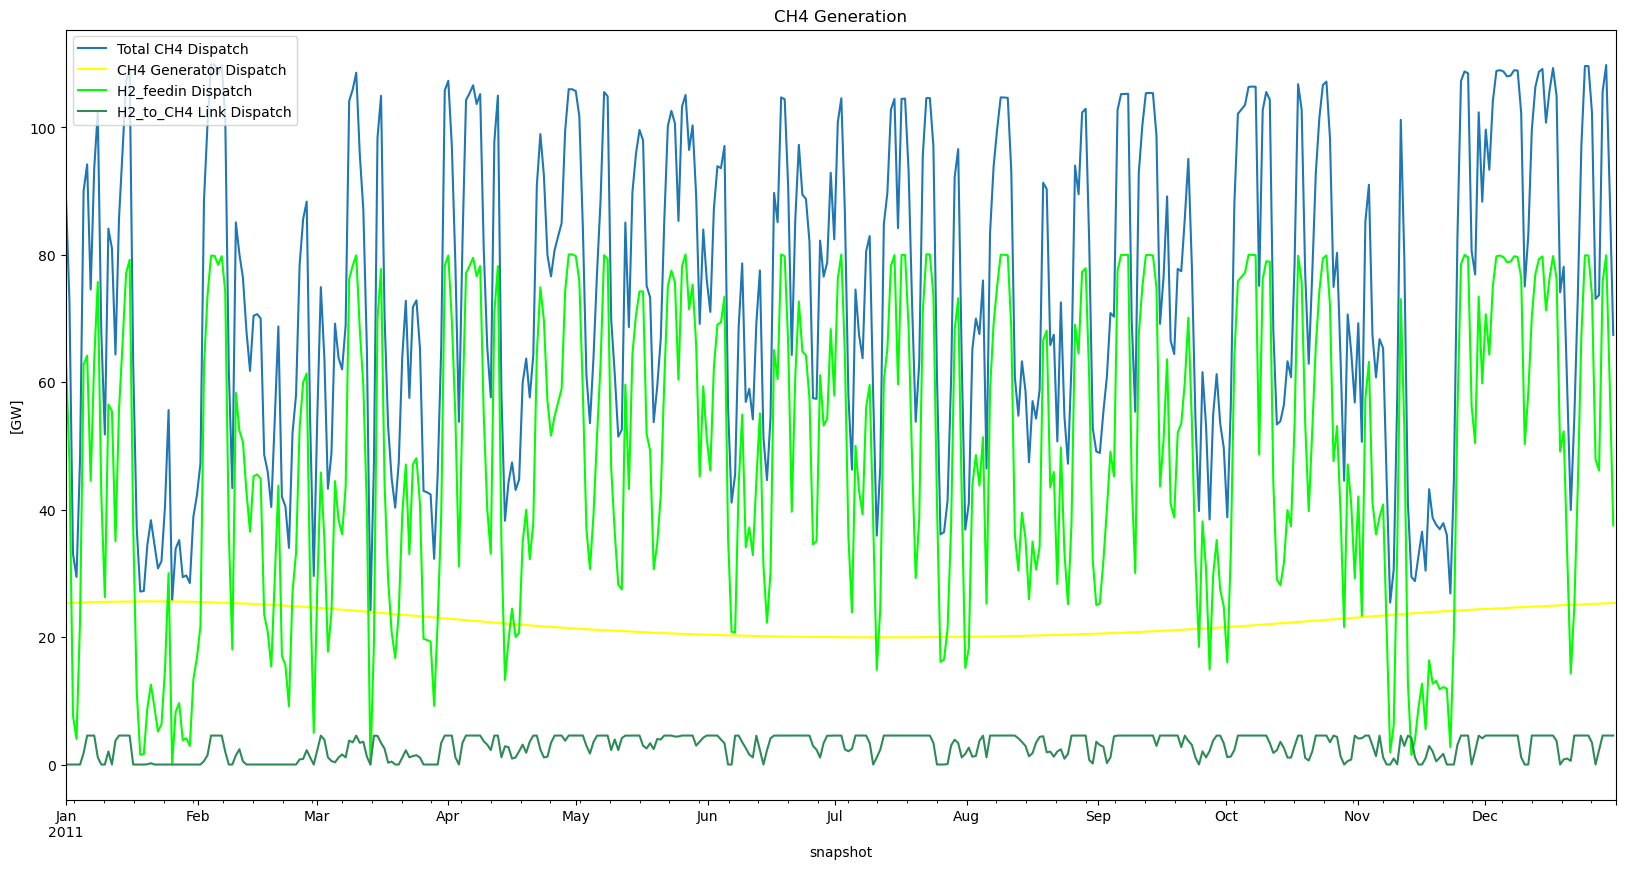

In [236]:
# Sources of CH4 over time?
# What are the possible sources?
# # # generators: 'CH4'
# # # links: 'H2_to_CH4', 'H2_feedin'
# stores not included because they dont generatre CH4
"""##### WHAT IS '''''Generator_biomass', 'Generator_gas'''?????????????###########"""

ch4_gens_feedin = network.generators_t.p[[col for col in network.generators_t.p.columns if 'CH4' in col]] # active power at bus
ch4_links_feedin = -network.links_t.p1[network.links.loc[network.links.carrier == 'H2_to_CH4'].index] #p1 is output p of H2_to_CH4
h2_links_feedin = -network.links_t.p1[network.links.loc[network.links.carrier == 'H2_feedin'].index]
# ch4_stores_feedin = network.stores_t.p[[col for col in network.stores_t.p.columns if 'CH4' in col]]

total_gen_per_t = ch4_gens_feedin.sum(axis = 1)/1e3
total_link_per_t = ch4_links_feedin.sum(axis = 1)/1e3
total_h2_per_t = h2_links_feedin.sum(axis=1)/1e3
# total_store_per_t = ch4_stores_feedin.sum(axis = 1)
# question: is H2_to_CH4 really that low or is there a conversion error?

a = (total_gen_per_t + total_link_per_t + total_h2_per_t).resample('20H').mean().plot(figsize = (20,10), title = "CH4 Generation", legend=True, ylabel = "[GW]", label = 'Total CH4 Dispatch')
total_gen_per_t.plot(ax = a, label = "CH4 Generator Dispatch", legend=True, color = colors()['CH4'])
total_h2_per_t.resample('20H').mean().plot(ax = a, label = "H2_feedin Dispatch", legend=True, color = colors()['H2_feedin'])
total_link_per_t.resample('20H').mean().plot(ax = a, label = "H2_to_CH4 Link Dispatch", legend=True, color = colors()['H2_to_CH4'])

#### Where is the CH4 generated?

(<matplotlib.collections.PatchCollection at 0x216deafda08>,
 <matplotlib.collections.LineCollection at 0x2169113f708>)

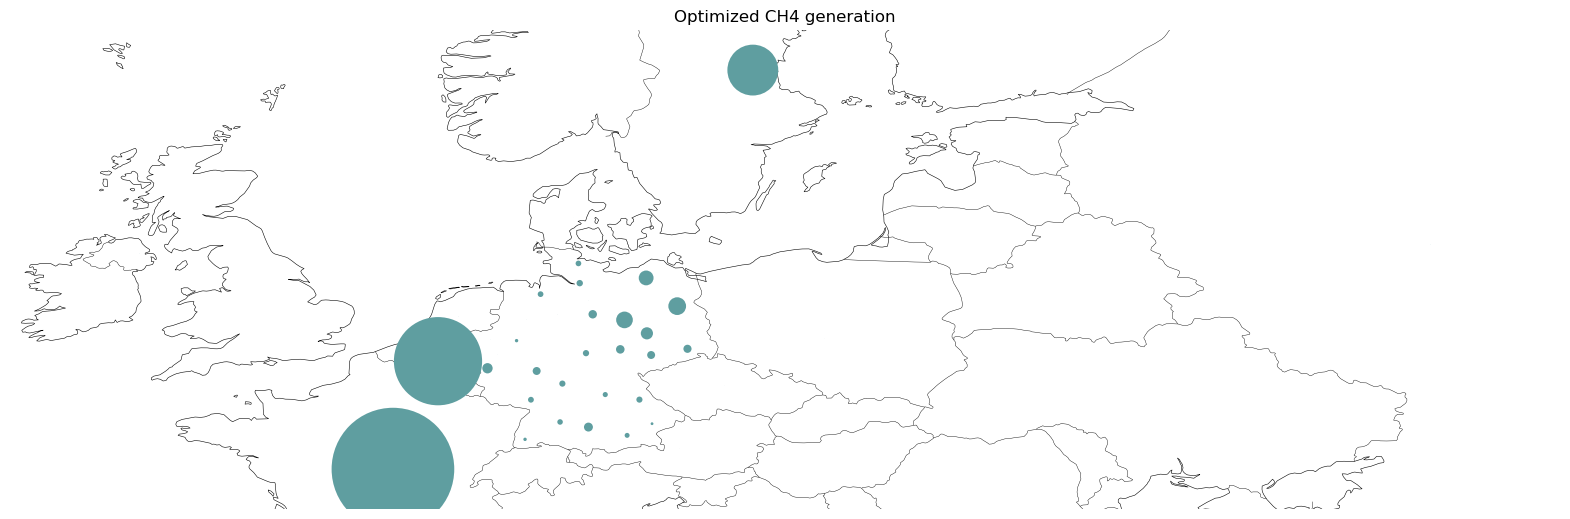

In [241]:
ch4_gen = network.generators.loc[network.generators.carrier == 'CH4']
capacities = network.generators_t.p[ch4_gen.index].sum(axis=0)

# remove 'CH4' from index to be able to use network.plot
new_idx = [i.replace(' CH4','') for i in capacities.index.to_list()]
capacities = pd.Series(capacities.values,index = new_idx)
scaling = 1/capacities.max()

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize = (20,10))
network.plot(
    bus_sizes=capacities * (scaling*5),
    #bus_colors=colors,
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,
    title = "Optimized CH4 generation")

In [159]:
capacities
# Significant foreign CH4 production capacities are located in FR, BE and SWE 

48631    4.508040e+01
48632    1.123223e+07
48634    4.977992e+01
48635    2.058805e+01
48636    2.171211e+07
48637    1.185190e+02
48638    2.281753e+01
48639    1.264599e+02
48641    4.438267e+01
48642    3.731149e+06
48644    1.343920e+02
72675    5.479974e+04
72676    9.281800e+01
72677    9.142967e+01
72678    6.072122e+01
72679    4.536979e+05
72680    3.540089e+04
72681    6.078187e+01
72682    1.062642e+02
72683    9.167068e+04
72684    9.124590e+04
72685    4.414491e+04
72686    9.576082e+04
72687    4.632426e+04
72688    1.031645e+05
72689    7.611422e+01
72690    3.776588e+04
72691    1.056774e+05
72692    3.166775e+05
72693    4.891291e+04
72694    1.656561e+04
72695    1.672239e+04
72696    1.152151e+05
72697    5.418671e+04
72698    1.141882e+04
72699    4.717833e+04
72700    5.895540e+04
72701    1.536729e+05
72702    4.007171e+05
72703    5.619417e+04
72704    2.138242e+05
dtype: float64

In [152]:
# Why is there only Gas Produced in FR, BE and SWE? Why not RUS
# Because of Biogas/Natural Gas prices? What about Gas in North Sea / NO? 
# Maybe problem of kmeans clustering?

#### What is the CH4 used for?

In [ ]:
# Use over CH4 over time (loads)
# What are the loads?
Links:
'industrial_gas_CHP', 'OCGT', 'CH4_to_H2', 'central_gas_CHP_heat','central_gas_boiler', 'rural_gas_boiler'
check:
'central_heat_store_charger', 'central_heat_store_discharger',
'rural_heat_store_charger', 'rural_heat_store_discharger']

Loads:
'CH4'

Generator:
'Generator_geo_thermal'
'Generator_central_biomass_CHP'
'Generator_central_biomass_CHP_heat'
'Generator_industrial_biomass_CHP'
'Generator_biomass'
'Generator_gas'
# Check modelling diagram

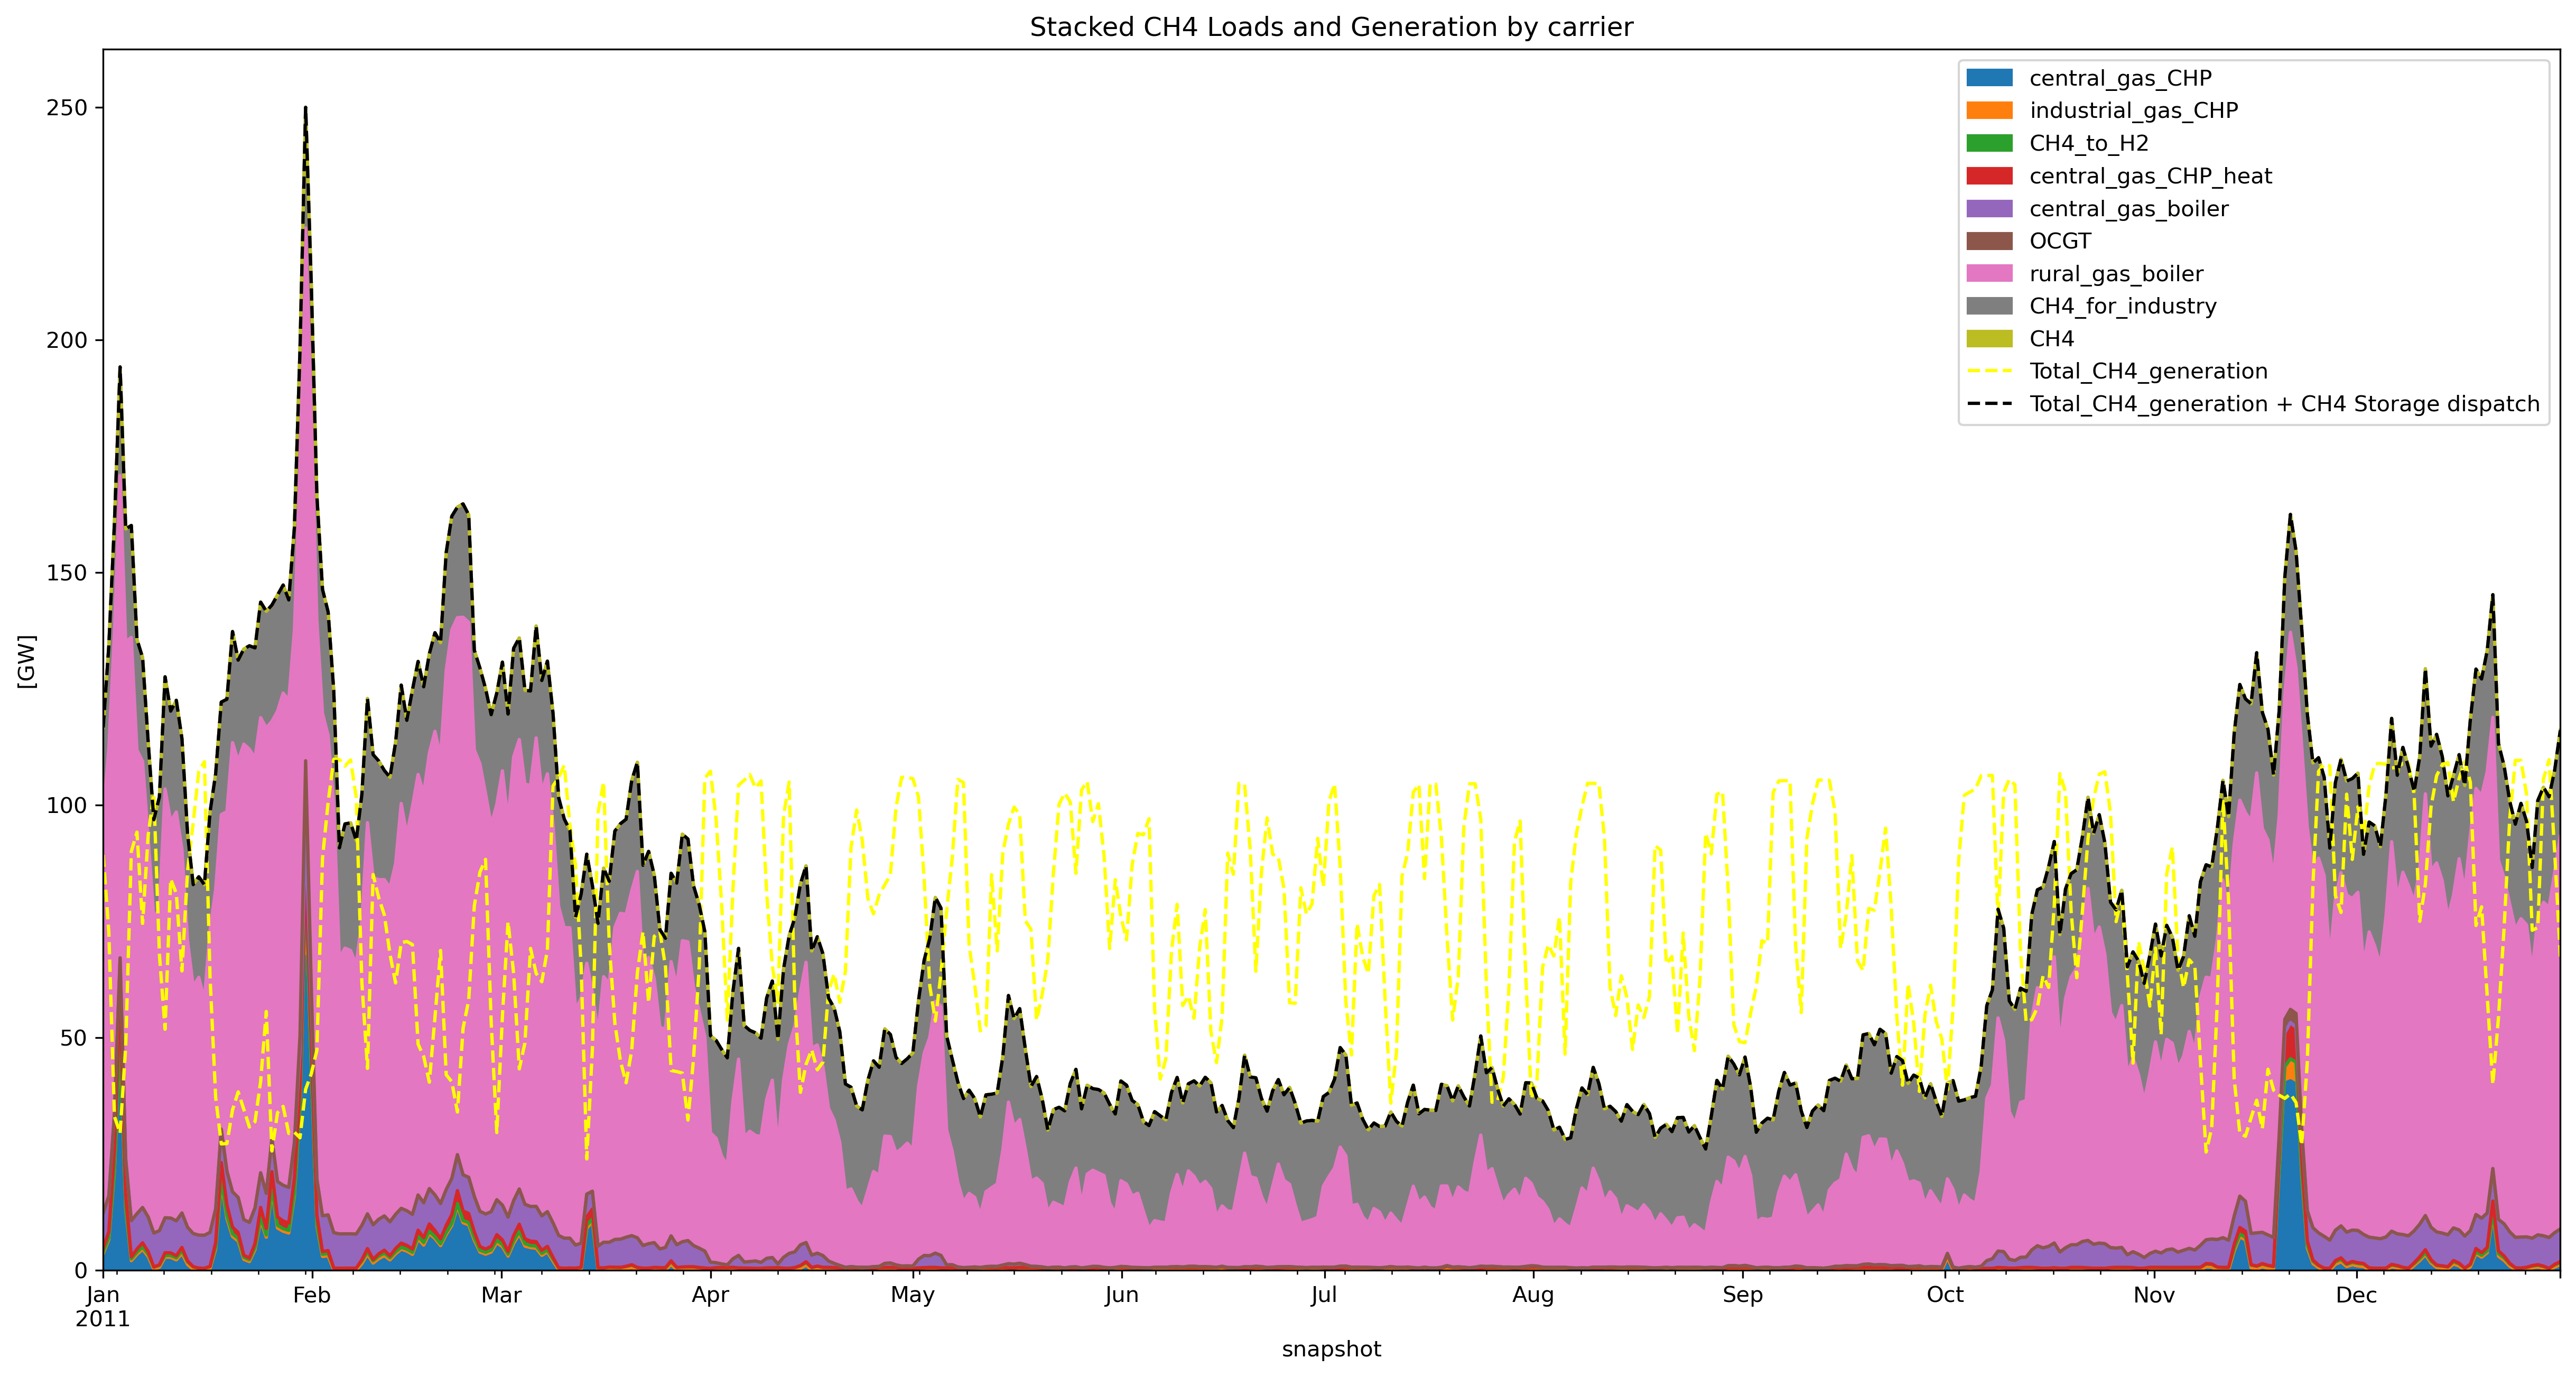

In [231]:
### CH4 related technologies ###

### Plot stacked CH4 related link loads ###
rel_ch4_loads = network.links.loc[network.links.bus0.isin(network.buses.loc[network.buses.carrier == 'CH4'].index)].carrier.unique()
rel_ch4_loads = np.delete(rel_ch4_loads, np.where(rel_ch4_loads == 'CH4'))

data = network.links_t.p0[network.links.loc[network.links.carrier == rel_ch4_loads[0]].index.to_list()]
data = pd.DataFrame(data.sum(axis=1)).resample('20H').mean()/1e3
data = data.rename(columns={0:rel_ch4_loads[0]})

for i in rel_ch4_loads[1:]:
    loads = network.links_t.p0[network.links.loc[network.links.carrier == i].index.to_list()]
    data[i] = loads.sum(axis=1).resample('20H').mean()/1e3

### add ch4 network.loads ###
ch4_load_carrier = ['rural_gas_boiler', 'CH4_for_industry', 'CH4']
for i in ch4_load_carrier:
    loads = network.loads_t.p[network.loads.loc[network.loads.carrier == i].index.to_list()]
    data[i] = loads.sum(axis=1).resample('20H').mean()/1e3

fig = plt.figure(figsize=(20, 10), dpi=300)
data.plot.area(ax = plt.gca(), title='Stacked CH4 Loads and Generation by carrier', ylabel = "[GW]", legend=True, stacked=True)

(total_gen_per_t + total_link_per_t + total_h2_per_t).resample('20H').mean().plot.line(legend=True, label = 'Total_CH4_generation',  color = colors()['CH4'], linestyle='dashed')#,linestyle='dashed')

stores=network.stores.loc[network.stores.carrier=='CH4']
a = (network.stores_t.p[stores.index].sum(axis=1)/1e3)
(total_gen_per_t + total_link_per_t + total_h2_per_t + a).resample('20H').mean().plot.line(legend=True, label = 'Total_CH4_generation + CH4 Storage dispatch',  color = 'black', linestyle='dashed')#,linestyle='dashed')

fig.savefig('asdf_CH4')

In [206]:
data.sum().sum()
(total_gen_per_t + total_link_per_t + total_h2_per_t).resample('20H').mean().sum()
# is equal so all loads are covered by dispatch

32415.4394612489

<AxesSubplot:xlabel='snapshot'>

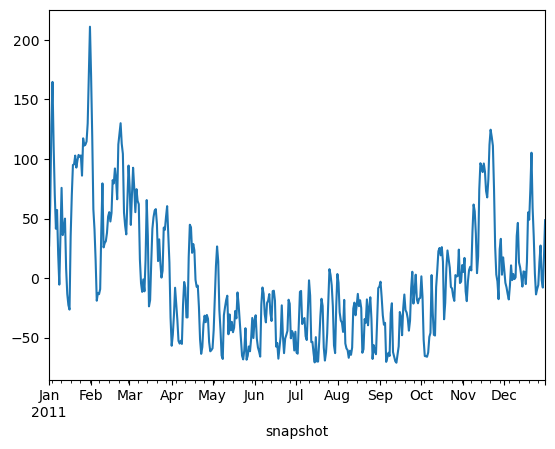

In [214]:
stores=network.stores.loc[network.stores.carrier=='CH4']
(network.stores_t.p[stores.index].sum(axis=1)/1e3).resample('20H').mean().plot()

Maximum mean dispatch over 20H
central_gas_CHP: 67.44504245721527
industrial_gas_CHP: 15.70895324935038
CH4_to_H2: 0.6626521897614172
central_gas_CHP_heat: 9.099395686363554
central_gas_boiler: 7.806194709521427
OCGT: 14.022069015626647
rural_gas_boiler: 125.3654828712849
CH4_for_industry: 27.61507059554942
CH4: 0.054010317010443336


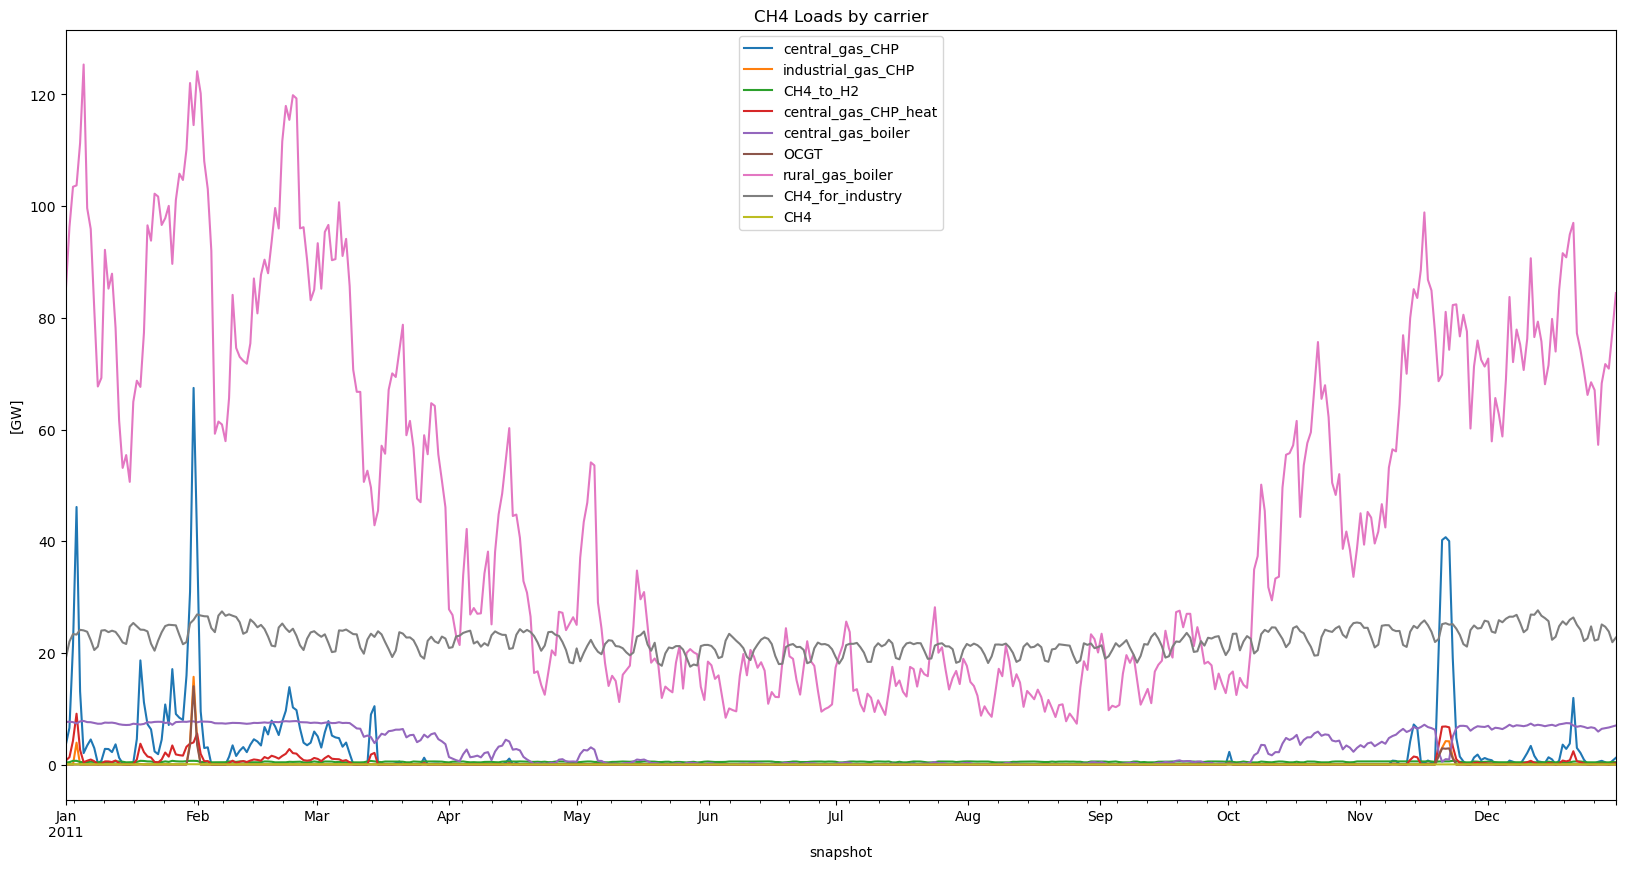

In [358]:
### CH4 related technologies ###
### plot non-stacked CH4 related link loads and loads

rel_ch4_loads = network.links.loc[network.links.bus0.isin(network.buses.loc[network.buses.carrier == 'CH4'].index)].carrier.unique()
rel_ch4_loads = np.delete(rel_ch4_loads, np.where(rel_ch4_loads == 'CH4'))

data = network.links_t.p0[network.links.loc[network.links.carrier == rel_ch4_loads[0]].index.to_list()]
data = data.sum(axis=1).resample('20H').mean()/1e3
plot = data.plot(figsize=(20, 10), title='CH4 Loads by carrier', label = rel_ch4_loads[0], ylabel = "[GW]", legend=True)

print('Maximum mean dispatch over 20H')
print(f'{rel_ch4_loads[0]}: {data.max()}')

for i in rel_ch4_loads[1:]:
    data = network.links_t.p0[network.links.loc[network.links.carrier == i].index.to_list()]
    data = data.sum(axis=1).resample('20H').mean()/1e3
    data.plot(ax = plot, label = i, legend=True)
    print(f'{i}: {data.max()}')

data = network.loads_t.p[network.loads.loc[network.loads.carrier == ch4_load_carrier[0]].index.to_list()]
data = data.sum(axis=1).resample('20H').mean()/1e3
data.plot(ax=plot, label = ch4_load_carrier[0], ylabel = "[GW]", legend=True)
print(f'{ch4_load_carrier[0]}: {data.max()}')

for i in ch4_load_carrier[1:]:
    data = network.loads_t.p[network.loads.loc[network.loads.carrier == i].index.to_list()]
    data = data.sum(axis=1).resample('20H').mean()/1e3
    data.plot(ax = plot, label = i, legend=True)
    print(f'{i}: {data.max()}')

- All carriers show strong seasonal behaviour except for 'CH4_to_H2' which provides small continuous demand the whole year around
- 'OCGT' have only two significant temporal intervals where they are put to use

# H2

<AxesSubplot:title={'center':'H2 Generation'}, xlabel='snapshot', ylabel='[GW]'>

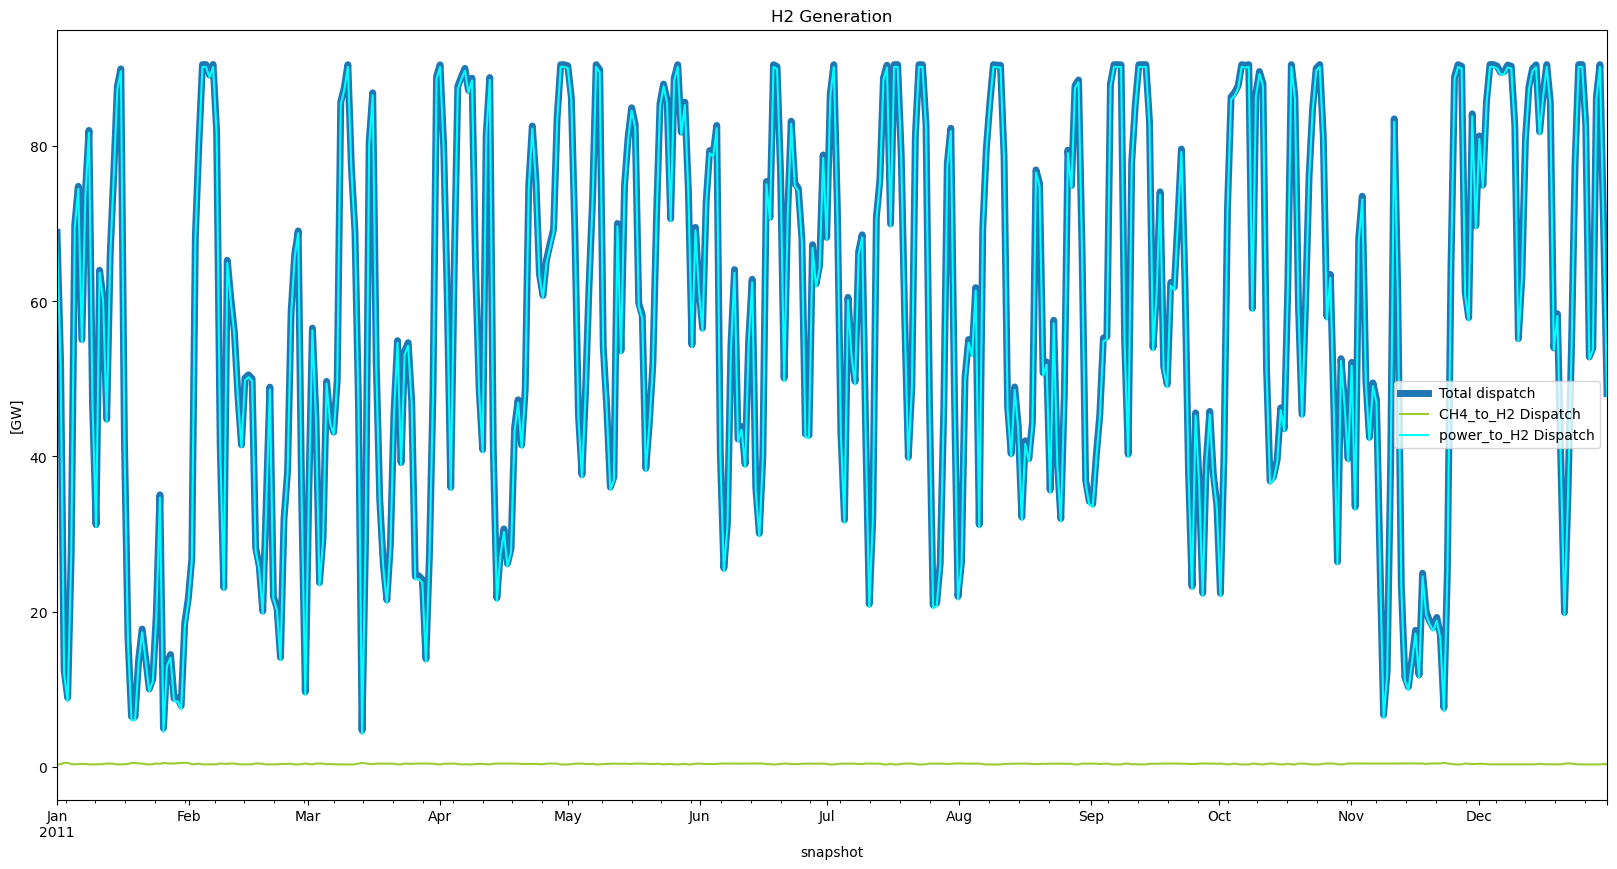

In [273]:
# Sources of H2 over time?
# What are the possible sources?
# # # links: 'power_to_H2', 'CH4_to_H2'
# stores not included because they dont generate H2

h2_CH4_gen = -network.links_t.p1[network.links.loc[network.links.carrier == 'CH4_to_H2'].index]
h2_power_gen = -network.links_t.p1[network.links.loc[network.links.carrier == 'power_to_H2'].index]

a = (h2_CH4_gen.sum(axis = 1)/1e3 + h2_power_gen.sum(axis = 1)/1e3).resample('20H').mean().plot(figsize = (20,10), title = "H2 Generation", legend=True, ylabel = "[GW]", label = 'Total dispatch', lw=5)
(h2_CH4_gen.sum(axis = 1)/1e3).resample('20H').mean().plot(ax = a, label = "CH4_to_H2 Dispatch", legend=True, color = colors()['CH4_to_H2'])
(h2_power_gen.sum(axis = 1)/1e3).resample('20H').mean().plot(ax = a, label = "power_to_H2 Dispatch", legend=True, color = colors()['power_to_H2'])

## Where is the H2 generated?

In [311]:
capacitiesCH4_H2 = pd.Series(h2_CH4_gen.sum().values, index = network.links.loc[h2_CH4_gen.sum().index].bus1.values)

capacitiesPower_H2 = pd.Series(h2_power_gen.sum().values, index = network.links.loc[h2_power_gen.sum().index].bus1.values)
capacitiesPower_H2 = capacitiesPower_H2.groupby(capacitiesPower_H2.index).sum()

H2_grid_capacities = capacitiesCH4_H2 + capacitiesPower_H2.loc[network.buses.loc[network.buses.carrier == 'H2_grid'].index]
H2_saltcavern_capacities = capacitiesPower_H2.loc[network.buses.loc[network.buses.carrier == 'H2_saltcavern'].index]

(<matplotlib.collections.PatchCollection at 0x21683efc608>,
 <matplotlib.collections.LineCollection at 0x216855b1308>)

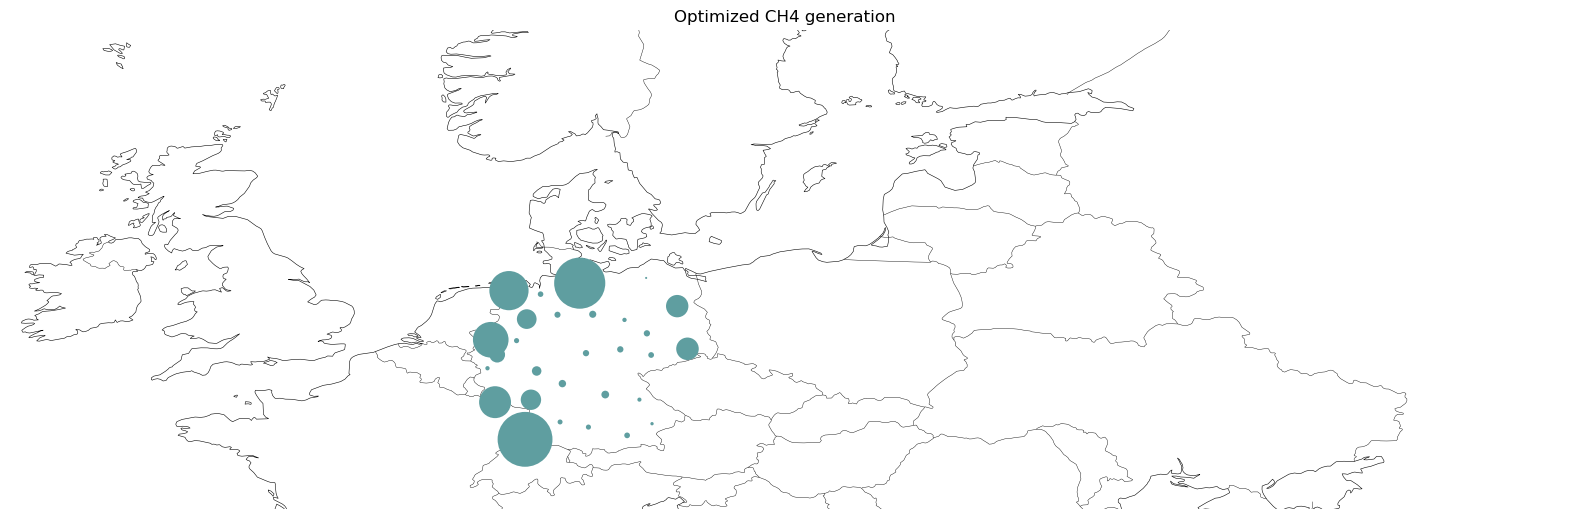

In [317]:
scaling = 1/H2_grid_capacities.max()

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize = (20,10))
network.plot(
    bus_sizes=H2_grid_capacities*scaling,
    #bus_colors=colors,
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,
    title = "H2 generation at H2_grid nodes")

(<matplotlib.collections.PatchCollection at 0x2169ec04448>,
 <matplotlib.collections.LineCollection at 0x216dc221dc8>)

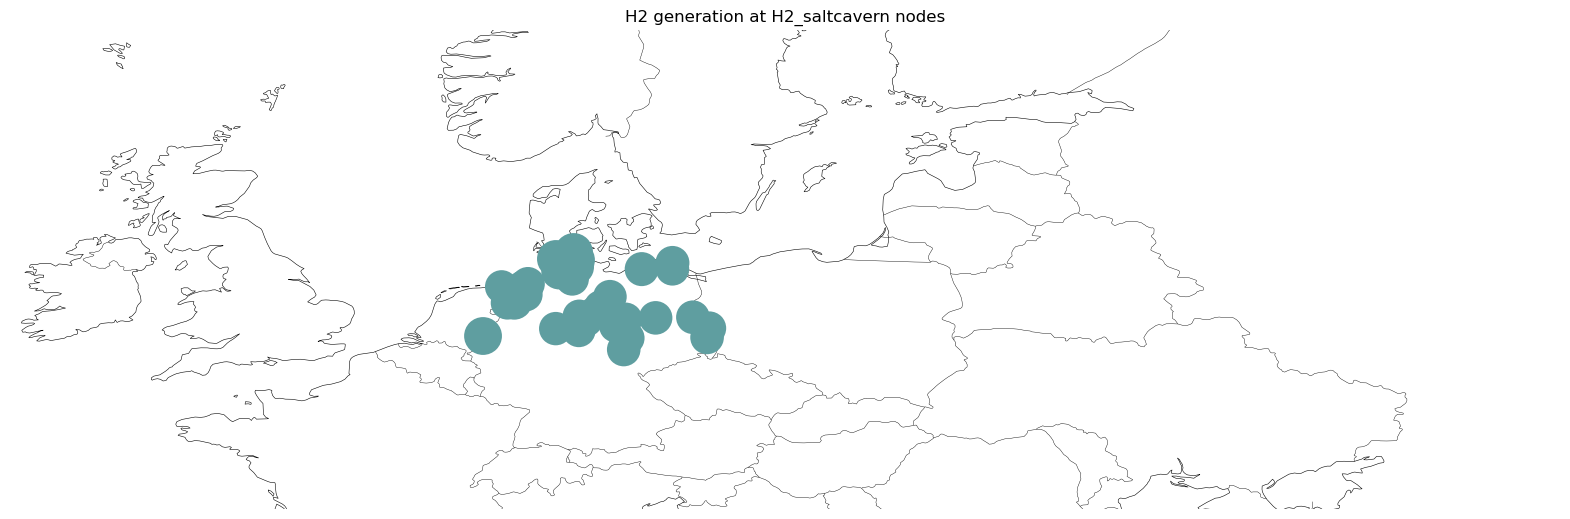

In [321]:
scaling = 1/H2_saltcavern_capacities.max()

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize = (20,10))
network.plot(
    bus_sizes=H2_saltcavern_capacities*scaling*.5,
    #bus_colors=colors,
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,
    title = "H2 generation at H2_saltcavern nodes")

## What is H2 used for?

In [345]:
h2_stores = network.stores.loc[network.stores.carrier.isin(['H2_underground', 'H2_overground'])]
h2_stores_dispatch = network.stores_t.p[h2_stores.index].sum(axis=1)

In [346]:
h2_stores_dispatch

snapshot
2011-01-01 00:00:00    106.616022
2011-01-01 05:00:00   -229.474355
2011-01-01 10:00:00   -132.822424
2011-01-01 15:00:00   -340.923852
2011-01-01 20:00:00    801.209436
                          ...    
2011-12-30 23:00:00   -210.888869
2011-12-31 04:00:00   -324.526480
2011-12-31 09:00:00    -47.995333
2011-12-31 14:00:00     37.369720
2011-12-31 19:00:00    511.802880
Length: 1752, dtype: float64

<AxesSubplot:title={'center':'Stacked H2 Loads by carrier'}, xlabel='snapshot', ylabel='[GW]'>

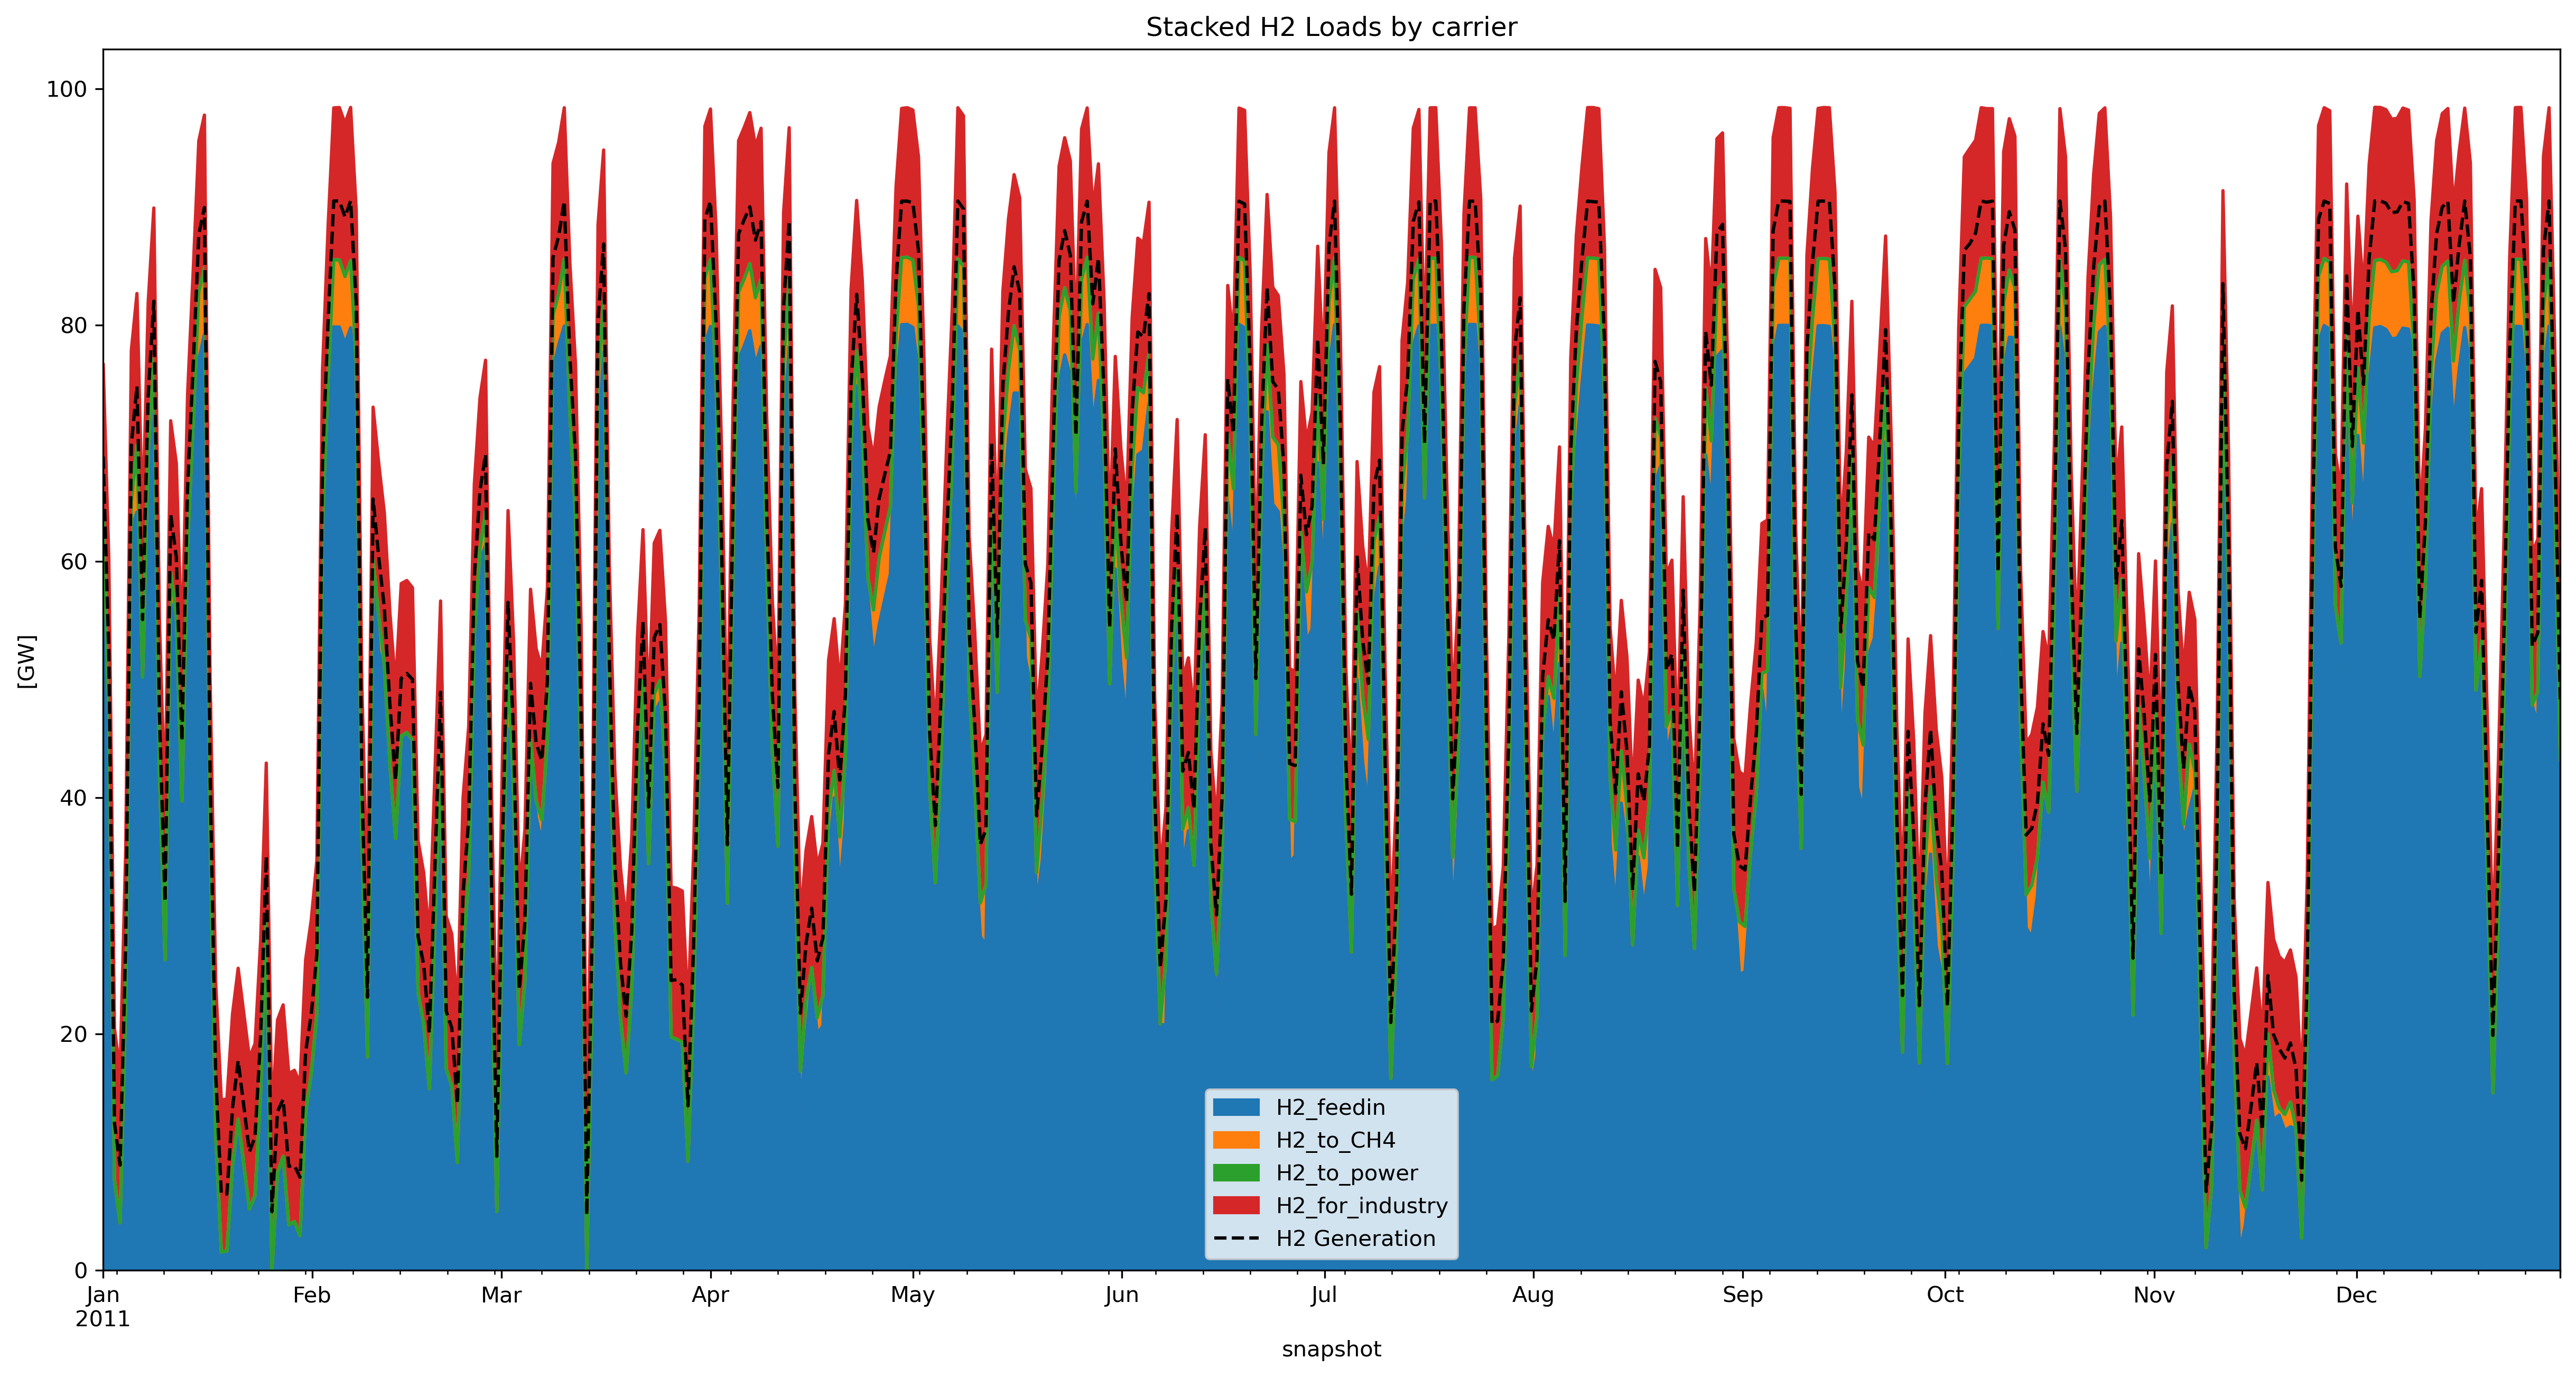

In [348]:
### H2 related technologies ###
# network.loads: 'H2_for_industry'
# network links: 'H2_feedin', 'H2_to_CH4', 'H2_to_power'

### Plot stacked H2 related link loads ###
rel_h2_links = ['H2_feedin', 'H2_to_CH4', 'H2_to_power']

data = network.links_t.p0[network.links.loc[network.links.carrier == rel_h2_links[0]].index.to_list()]
data = pd.DataFrame(data.sum(axis=1)).resample('20H').mean()/1e3
data = data.rename(columns={0:rel_h2_links[0]})

for i in rel_h2_links[1:]:
    loads = network.links_t.p0[network.links.loc[network.links.carrier == i].index.to_list()]
    data[i] = loads.sum(axis=1).resample('20H').mean()/1e3

### add ch4 network.loads ###
rel_h2_loads = ['H2_for_industry']
for i in rel_h2_loads:
    loads = network.loads_t.p[network.loads.loc[network.loads.carrier == i].index.to_list()]
    data[i] = loads.sum(axis=1).resample('20H').mean()/1e3

fig = plt.figure(figsize=(20, 10), dpi=300)
data.plot.area(ax = plt.gca(), title='Stacked H2 Loads by carrier', ylabel = "[GW]", legend=True, stacked=True)

(h2_CH4_gen.sum(axis = 1)/1e3 + h2_power_gen.sum(axis = 1)/1e3).resample('20H').mean().plot(ax = plt.gca(), legend = True, label='H2 Generation', color='black', linestyle='dashed')

# What is missing in the generation? Where does the difference come from?

Maximum mean dispatch over 20H
H2_feedin: 80.05492351891424
H2_to_CH4: 5.6841680434523205
H2_to_power: 0.0008988864723606709
H2_for_industry: 12.982291652841969


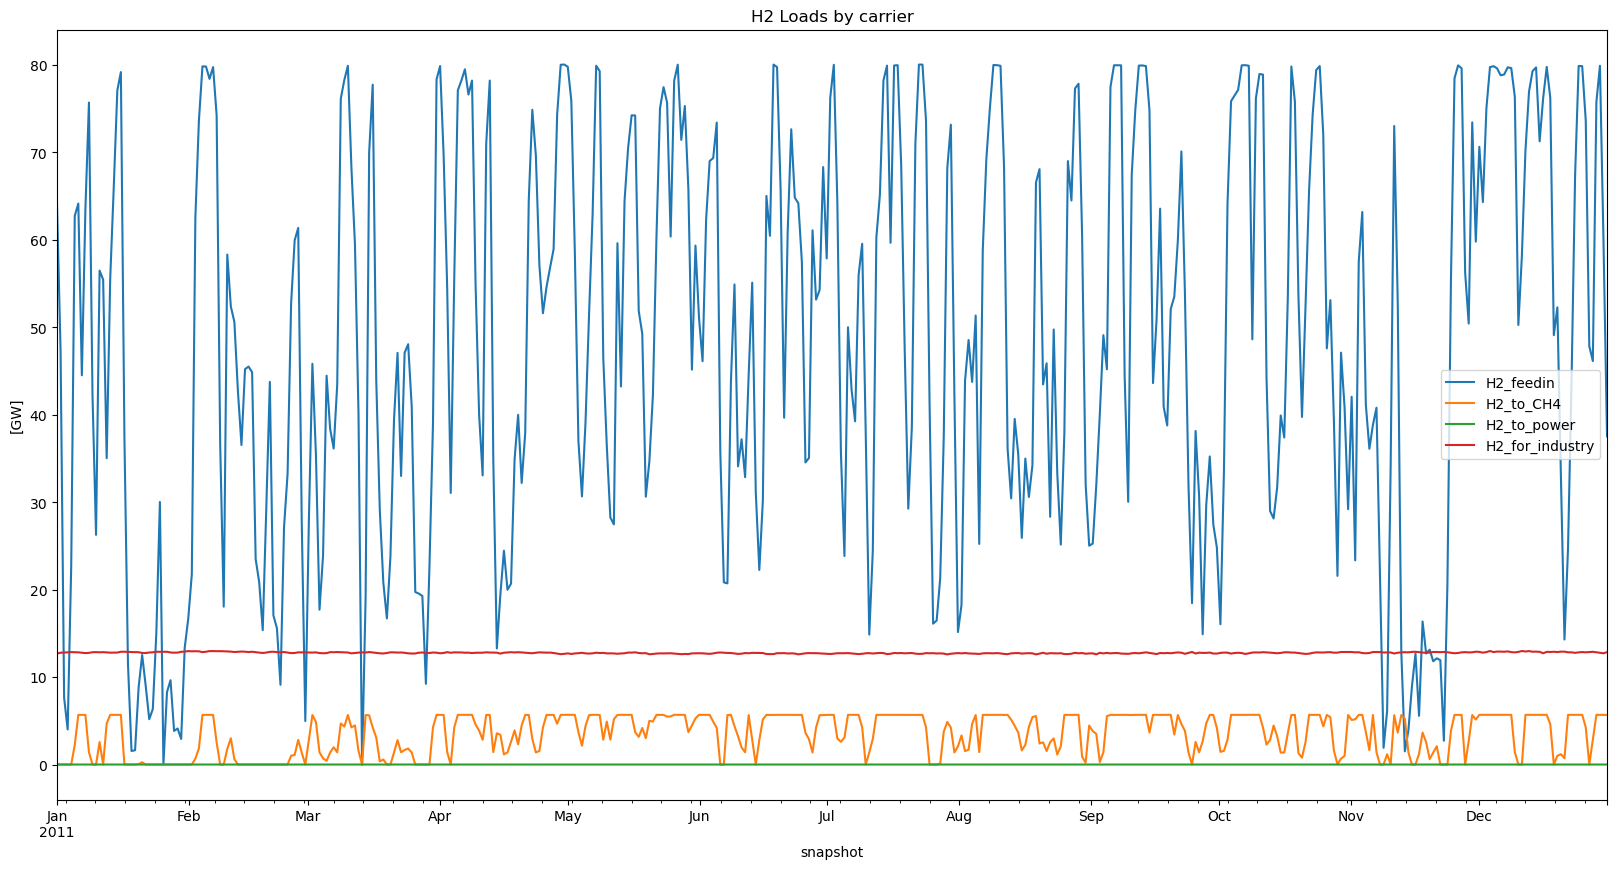

In [359]:
### H2 related technologies ###
### plot non-stacked H2 related link loads and loads

rel_h2_links = ['H2_feedin', 'H2_to_CH4', 'H2_to_power']

data = network.links_t.p0[network.links.loc[network.links.carrier == rel_h2_links[0]].index.to_list()]
data = data.sum(axis=1).resample('20H').mean()/1e3
plot = data.plot(figsize=(20, 10), title='H2 Loads by carrier', label = rel_h2_links[0], ylabel = "[GW]", legend=True)

print('Maximum mean dispatch over 20H')
print(f'{rel_h2_links[0]}: {data.max()}')

for i in rel_h2_links[1:]:
    data = network.links_t.p0[network.links.loc[network.links.carrier == i].index.to_list()]
    data = data.sum(axis=1).resample('20H').mean()/1e3
    data.plot(ax = plot, label = i, legend=True)
    print(f'{i}: {data.max()}')

data = network.loads_t.p[network.loads.loc[network.loads.carrier == rel_h2_loads[0]].index.to_list()]
data = data.sum(axis=1).resample('20H').mean()/1e3
data.plot(ax=plot, label = rel_h2_loads[0], ylabel = "[GW]", legend=True)
print(f'{rel_h2_loads[0]}: {data.max()}')

# Investigate Gas (CH4, H2) Storages

CH4 total storage capacity:7.34e+02 TWh
CH4 Maximum fill (%): 61.1
168278583.54472613
H2_overground total storage capacity:0.00487 TWh
H2_overground Maximum fill (%): 99.8
4848.437354982533
H2_underground total storage capacity:0.001 TWh
H2_underground Maximum fill (%): 39.9
106.55640598452078


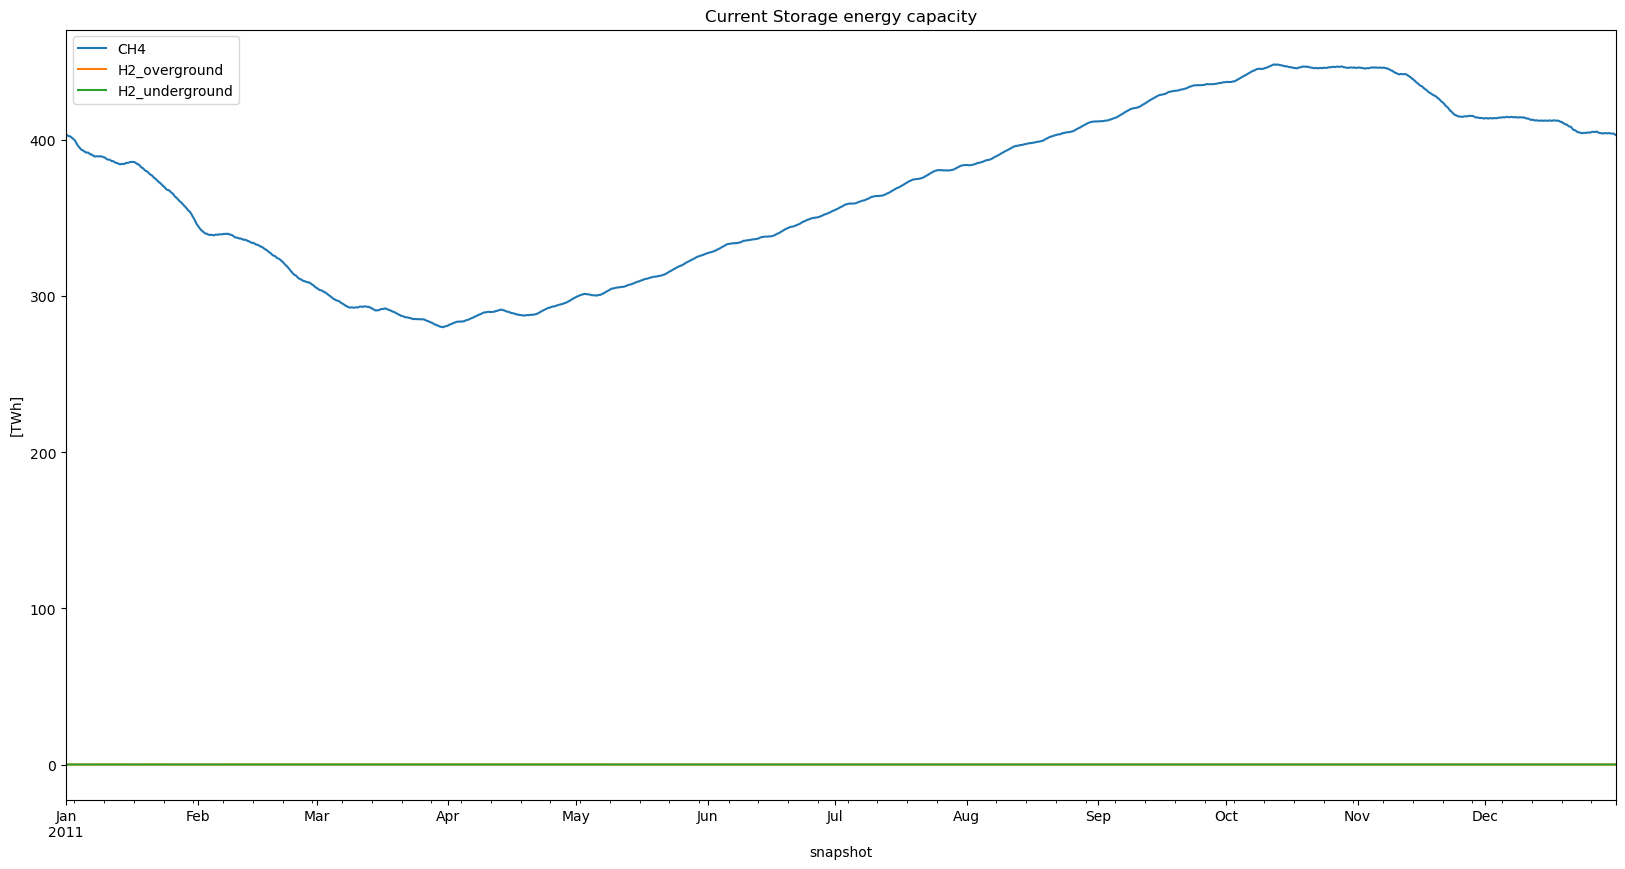

In [233]:
gas_storage_techs = ['CH4', 'H2_overground', 'H2_underground']
for i in gas_storage_techs:
    stores = network.stores.loc[network.stores.carrier == i]
    print(f'{i} total storage capacity:{stores.e_nom_opt.sum()/1e6:.3} TWh')
    print(f'{i} Maximum fill (%): {network.stores_t.e[stores.index].sum(axis = 1).max()/stores.e_nom_opt.sum()*100:.3}')
    (network.stores_t.e[stores.index].sum(axis = 1)/1e6).plot(title = 'Current Storage energy capacity',figsize=(20,10), ylabel='[TWh]',label = i, legend= True)

In [96]:
f_c = network.links.loc[network.links.carrier == 'H2_to_power'].p_nom_opt.sum()
print(f'Total Fuel Cell capacity: {f_c:.3} MW')

Total Fuel Cell capacity: 2.19 MW


In [222]:
electrolyzer = network.links.loc[network.links.carrier == 'power_to_H2'].p_nom_opt.sum()/1e3
print(f'Total Fuel Cell capacity: {electrolyzer:.3} GW')

Total Fuel Cell capacity: 1.29e+02 GW


In [223]:
methanization = network.links.loc[network.links.carrier == 'H2_to_CH4'].p_nom_opt.sum()/1e3
print(f'Total Fuel Cell capacity: {methanization:.3} GW')

Total Fuel Cell capacity: 5.69 GW


In [229]:
h2f = network.links.loc[network.links.carrier == 'H2_feedin'].p_nom_opt.sum()/1e3
print(f'Total Fuel Cell capacity: {h2f:.3} GW')

Total Fuel Cell capacity: 2.71e+03 GW


In [230]:
network.links.loc[network.links.carrier == 'H2_feedin'].p_nom.sum()/1e3

2705.616399048361

- Neglectable H2 storage Capacities (~0) -> No energy flexibility arising out of H2 technologies
- CH4 Storages show good seasonal behaviour, Only ~61% of available CH4 storage capacity is used


# Investigate Heat Sector

In [165]:
gas_boilers = network.links.loc[network.links.carrier == 'rural_gas_boiler']
gas_boilers.p_nom.sum()
### -> between mid October to end of March rural_gas_boiler always work on full capacity
### Does that make sense? Are there heat-loads shedded? Do central_gas_boilers work as flexibility and rural_gas_boiler provide base_loads?

0.0

<AxesSubplot:title={'center':'Central and rural heat loads'}, xlabel='snapshot', ylabel='[MW]'>

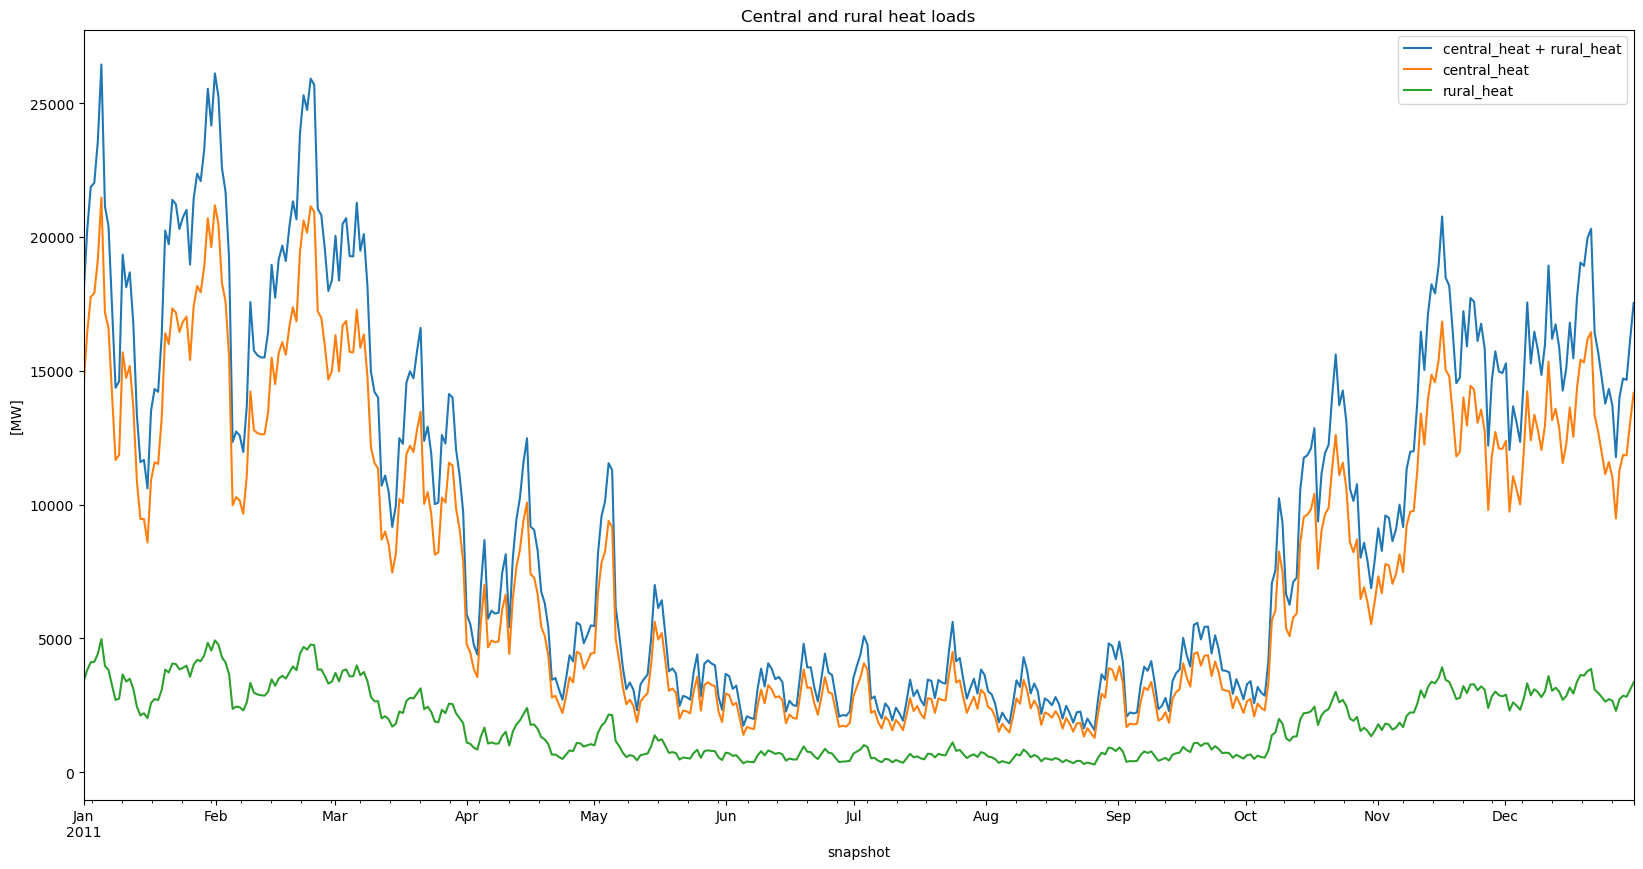

In [14]:
central_h = network.loads.loc[network.loads.carrier == 'central_heat']
rural_h = network.loads.loc[network.loads.carrier == 'rural_heat']
central_h_loads = network.loads_t.p[central_h.index].sum(axis = 1)
rural_h_loads = network.loads_t.p[rural_h.index].sum(axis = 1)

(central_h_loads + rural_h_loads).resample('20H').mean().plot(figsize=(20,10), title = 'Central and rural heat loads', label = 'central_heat + rural_heat', legend= True, ylabel='[MW]')
central_h_loads.resample('20H').mean().plot(label = 'central_heat', legend= True)
rural_h_loads.resample('20H').mean().plot(label = 'rural_heat', legend= True)

In [227]:
network.loads.carrier.unique()

array(['AC', 'H2 for industry', 'CH4', 'H2', 'central_heat', 'rural_heat',
       'land transport EV'], dtype=object)

<AxesSubplot:title={'center':'Stacked Heat Generation'}, xlabel='snapshot', ylabel='[MW]'>

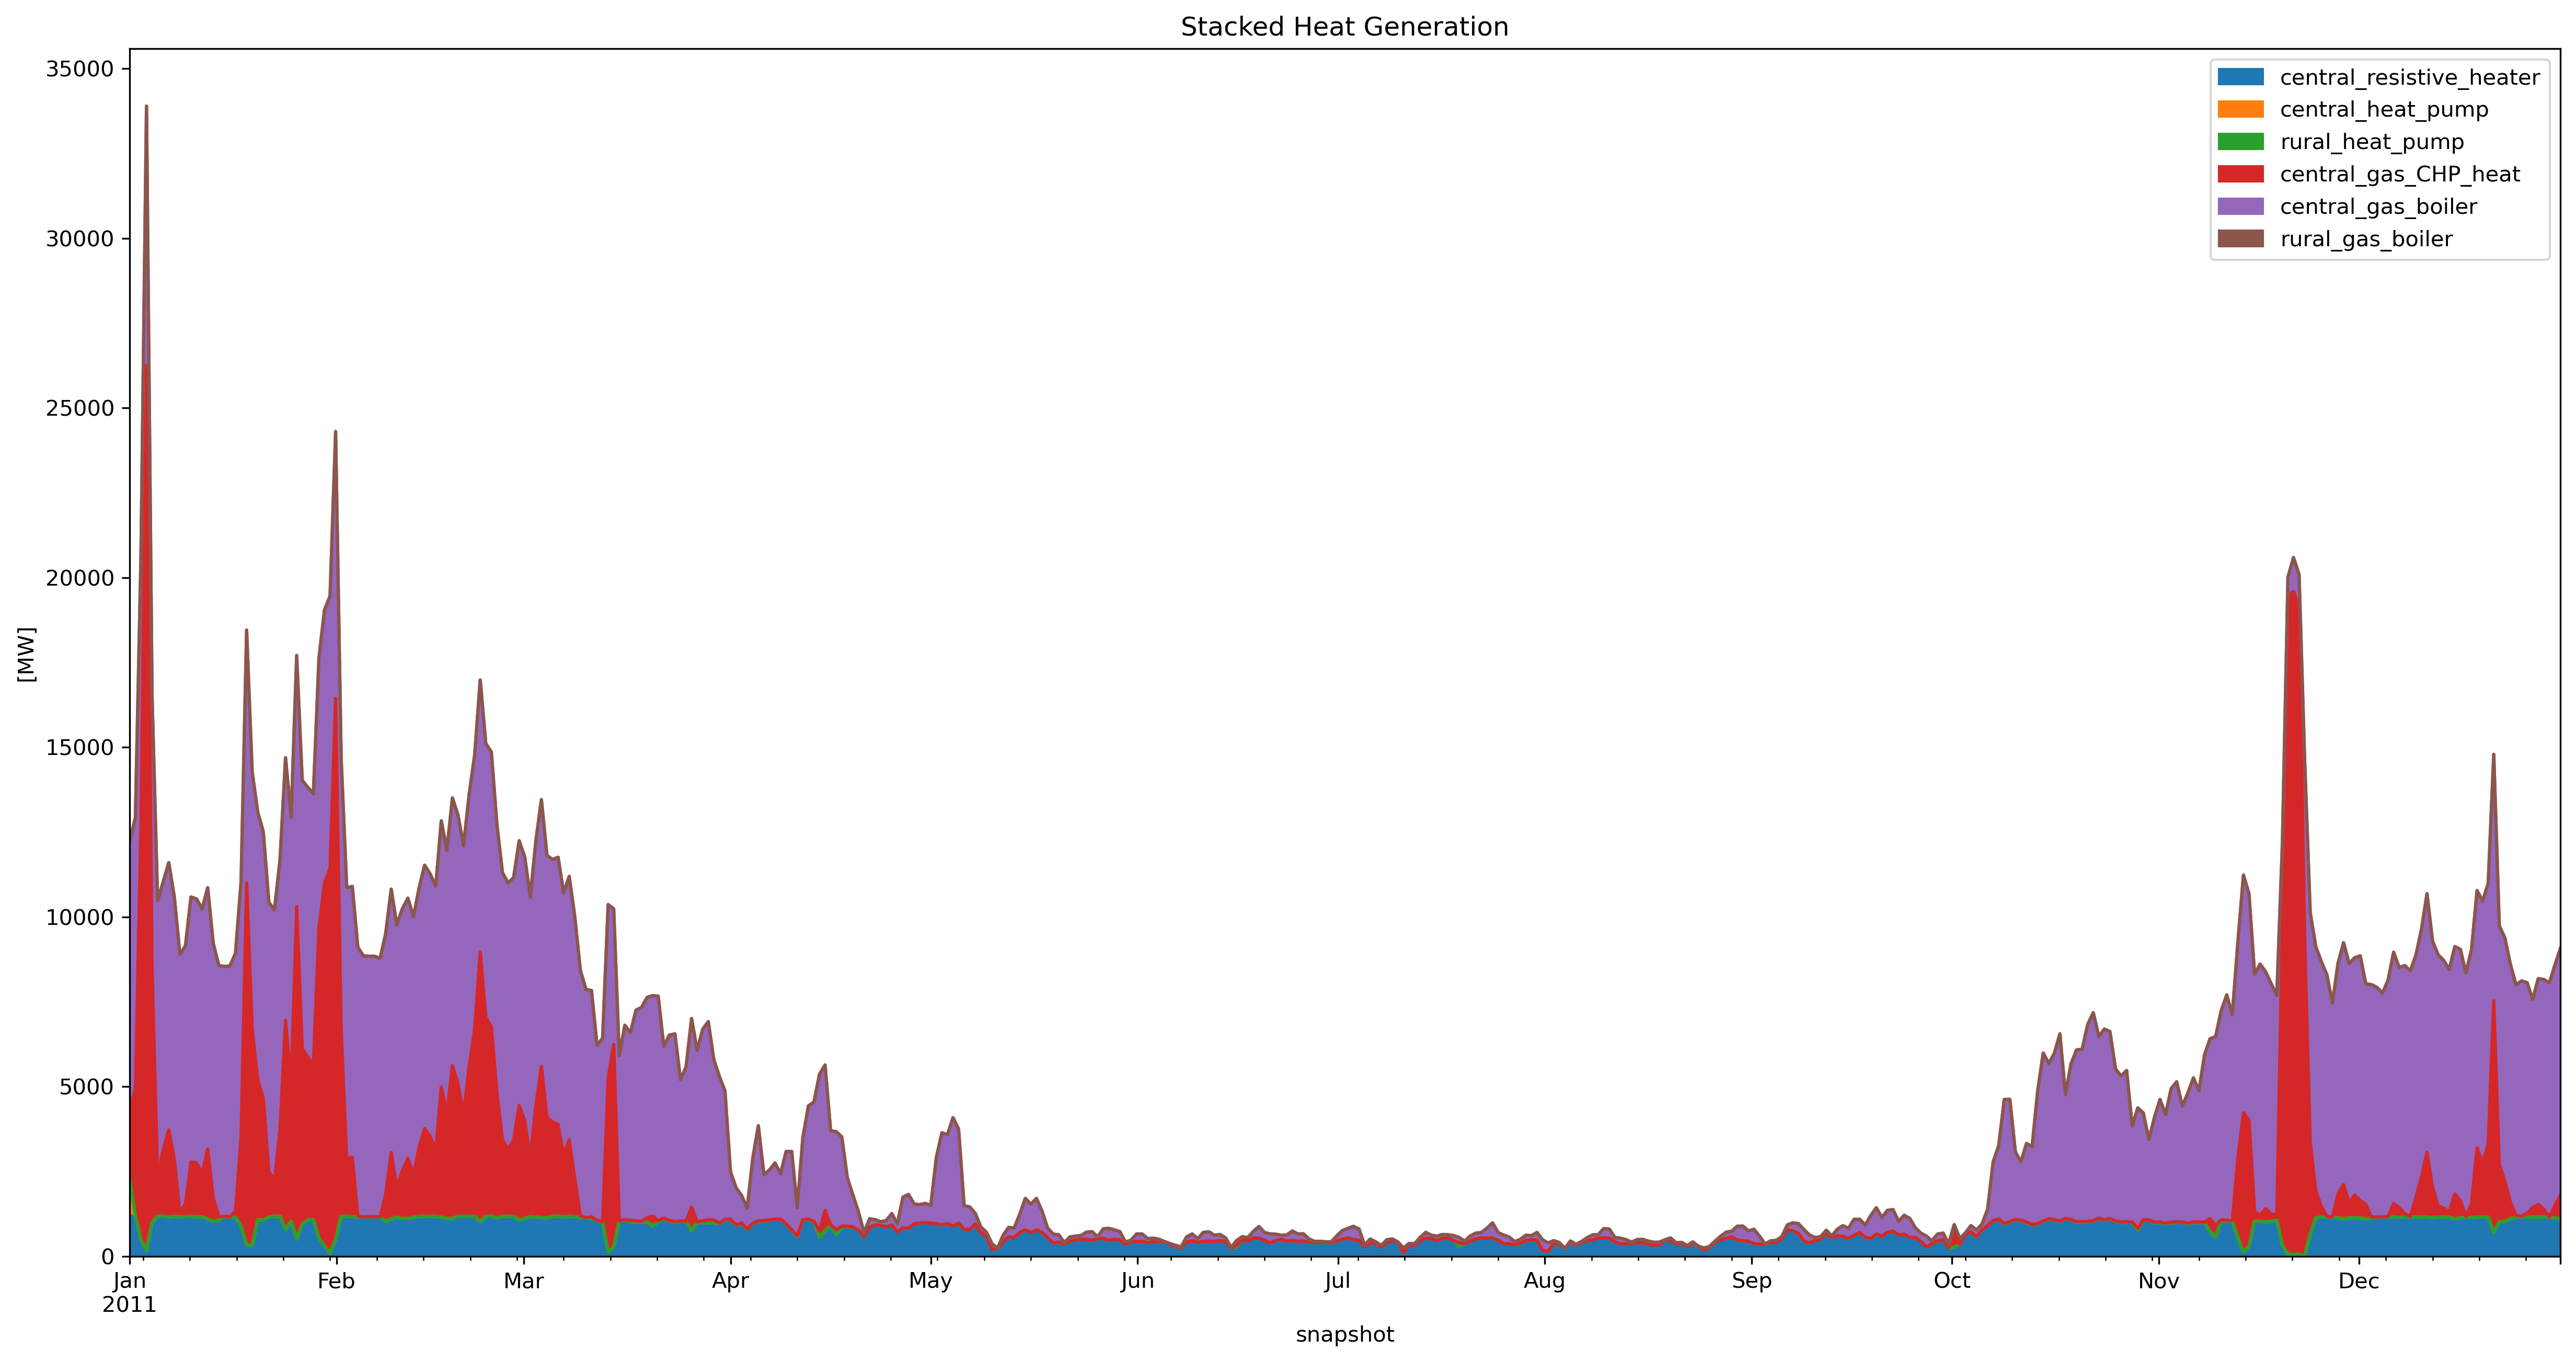

In [15]:
heat_gen_techs = ['central_resistive_heater', 'central_heat_pump', 'rural_heat_pump', 'central_gas_CHP_heat', 'central_gas_boiler', 'rural_gas_boiler']

data = network.links_t.p1[network.links.loc[network.links.carrier == heat_gen_techs[0]].index.to_list()]
data = pd.DataFrame(-(data.sum(axis=1))).resample('20H').mean()
data = data.rename(columns={0:heat_gen_techs[0]})

for i in heat_gen_techs[1:]:
    loads = network.links_t.p1[network.links.loc[network.links.carrier == i].index.to_list()]
    data[i] = -(loads).sum(axis=1).resample('20H').mean()

fig = plt.figure(figsize=(20, 10), dpi=300)
#(central_h_loads + rural_h_loads).resample('20H').mean().plot(ax = plt.gca(), label='central_heat + rural_heat Loads', legend=True)
data.plot.area(ax = plt.gca(), title='Stacked Heat Generation', ylabel = "[MW]", legend=True, stacked=True)

In [272]:
r_heat_pumps = network.links.loc[network.links.carrier == 'rural_heat_pump']
((r_heat_pumps.p_nom_opt)>0).sum()
#network.links_t.p1[b.index].sum(axis=1).plot()
# werden sie überhaupt gebaut?
# Wieso gibt es mehr r_heat_pumps als AC Busse?

445

In [275]:
network.buses.carrier.value_counts()

AC                    300
dsm                   285
Li ion                285
H2_saltcavern          74
rural_heat             52
rural_heat_store       52
CH4                    42
H2_grid                29
central_heat           29
central_heat_store     29
H2_ind_load            15
Name: carrier, dtype: int64

In [273]:
c_heat_pumps = network.links.loc[network.links.carrier == 'central_heat_pump']
((c_heat_pumps.p_nom_opt)>0).sum()
#network.links_t.p1[b.index].sum(axis=1).plot()
# werden sie überhaupt gebaut?

280

In [264]:
a = network.links.loc[network.links.carrier == 'central_heat_pump']
network.links_t.p1[a.index].sum(axis=1)

snapshot
2011-01-01 00:00:00   -2283.515598
2011-01-01 05:00:00       0.000000
2011-01-01 10:00:00       0.000000
2011-01-01 15:00:00       0.000000
2011-01-01 20:00:00       0.000000
                          ...     
2011-12-30 23:00:00       0.000000
2011-12-31 04:00:00       0.000000
2011-12-31 09:00:00       0.000000
2011-12-31 14:00:00       0.000000
2011-12-31 19:00:00       0.000000
Length: 1752, dtype: float64

<AxesSubplot:xlabel='snapshot'>

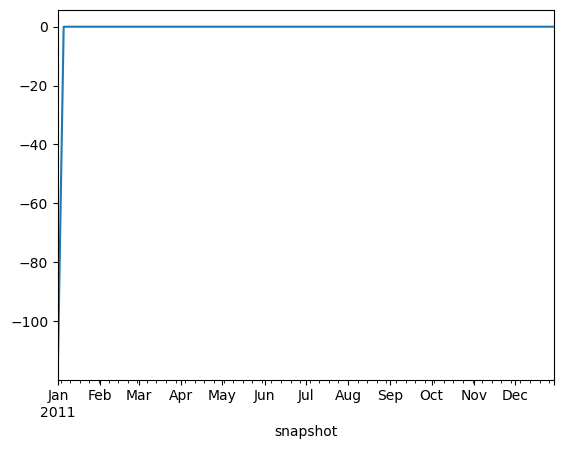

In [262]:
network.links_t.p1[a.index].sum(axis=1).resample('100H').mean().plot()

In [224]:
heat_gen_techs = ['central_resistive_heater', 'central_heat_pump', 'rural_heat_pump', 'central_gas_CHP_heat', 'central_gas_boiler', 'rural_gas_boiler']

data = network.links_t.p1[network.links.loc[network.links.carrier == heat_gen_techs[0]].index.to_list()]
data = pd.DataFrame(-(data.sum(axis=1)))
data = data.rename(columns={0:heat_gen_techs[0]})

for i in heat_gen_techs[1:]:
    loads = network.links_t.p1[network.links.loc[network.links.carrier == i].index.to_list()]
    data[i] = -(loads).sum(axis=1)

In [229]:
# 'central_heat_store', 'rural_heat_store'
a = network.stores.loc[network.stores.carrier == 'central_heat_store']
b = network.stores.loc[network.stores.carrier == 'rural_heat_store']

<AxesSubplot:xlabel='snapshot'>

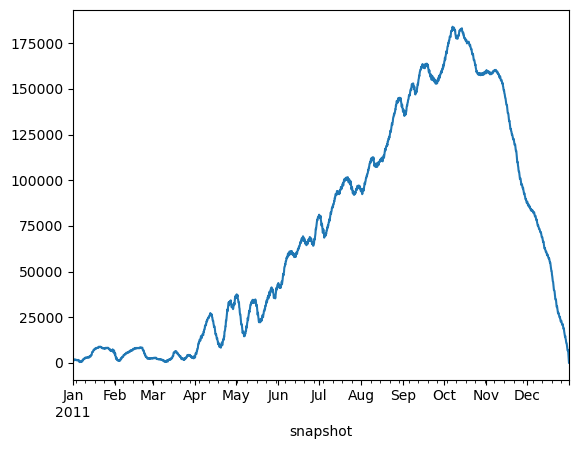

In [247]:
(-network.stores_t.p[a.index].sum(axis=1).cumsum()).plot()

In [225]:
# all heat generated by links
data.sum().sum()

77976100.24771644

In [226]:
(central_h_loads + rural_h_loads).sum()

# looks like there is a 20 TW difference

98415632.28588265

In [154]:
a=network.stores_t.e[[col for col in network.stores_t.e.columns if 'CH4' in col]].sum(axis=1)
a.max()
# data = network.links_t.p0[network.links.loc[network.links.carrier == rel_ch4_loads[0]].index.to_list()]
# data = pd.DataFrame(data.sum(axis=1)).resample('20H').mean()
# data = data.rename(columns={0:rel_ch4_loads[0]})

114896924.9105341

In [ ]:
# Cummulative use of CH4
# direct consumption 
# stores

In [3]:
network.buses = network.buses[network.buses.country == 'DE']# & (network.buses.carrier == 'CH4')]
network.links = network.links[network.links.bus0.isin(network.buses.index) & network.links.bus1.isin(network.buses.index) & (network.links.carrier == 'CH4')]

In [ ]:
PLOT H2 STORAGES ALL ON ONE MAP
PLOT PIE CHART OF STORAGE capacities
PLOT PI CHART OF STORAGE COSTS

In [5]:
H2_overground = network.stores[network.stores.carrier == 'H2_overground']
H2_underground = network.stores[network.stores.carrier == 'H2_underground'] #underground has e_nom_opt=0 for all entries

capacities = H2_overground.e_nom_opt.groupby([network.stores.bus, network.stores.carrier]).sum()
scaling = 1/(max(abs(capacities.groupby(level=0).sum())))

In [108]:
capacities = H2_underground.e_nom_opt.groupby([network.stores.bus, network.stores.carrier]).sum()
scaling = 1/(max(abs(capacities.groupby(level=0).sum())))
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize = (9,9))
network.plot(
    bus_sizes=capacities * scaling,
    bus_colors=colors(),
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,
    title = "Optimised CH4 generation")


NameError: name 'H2_underground' is not defined

In [6]:
capacities2 = H2_overground.e_nom_opt.groupby([network.stores.bus, network.stores.carrier]).sum()+100

(<matplotlib.collections.PatchCollection at 0x28390de8948>,
 <matplotlib.collections.LineCollection at 0x283946ed208>)

C:\ProgramData\mambaforge\envs\etrago\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\ProgramData\mambaforge\envs\etrago\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


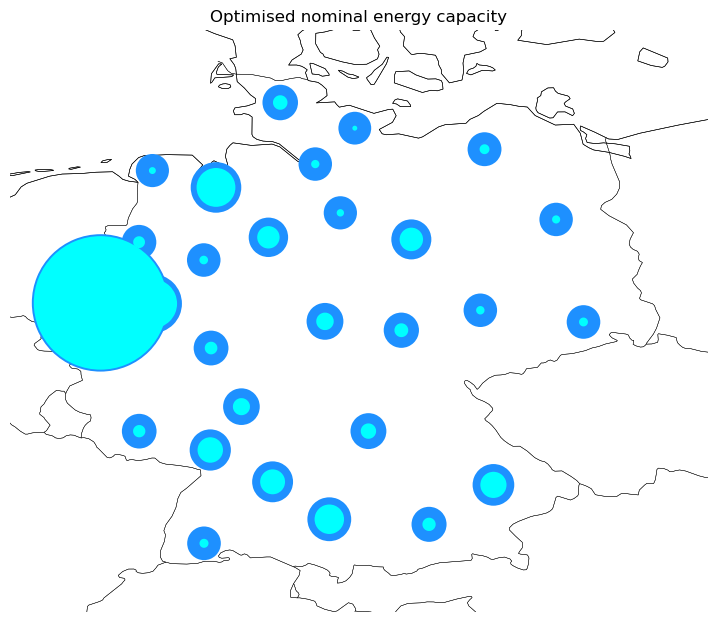

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()}, figsize = (9,9))
colors = tools.plot.coloring()
colors2 = coloring2()
network.plot(
    bus_sizes=capacities2 * scaling,
    bus_colors=colors2,
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,)

network.plot(
    bus_sizes=capacities * scaling,
    bus_colors=colors,
    line_widths=0,
    link_widths=0,
    margin=0.1,
    ax=ax,
    title = "Optimised nominal energy capacity")





In [97]:
capacities2

bus    carrier      
77860  H2_overground     417.910569
77861  H2_overground     616.328548
77862  H2_overground    1664.948392
77863  H2_overground     466.244164
77864  H2_overground    7290.661376
77865  H2_overground    1001.080502
77866  H2_overground     943.023643
77867  H2_overground    1685.249363
77868  H2_overground     798.480725
77869  H2_overground    1690.547424
77870  H2_overground     156.998191
77871  H2_overground    3027.610087
77872  H2_overground     288.931335
77873  H2_overground     634.607175
77874  H2_overground     630.504440
77875  H2_overground     737.383522
77876  H2_overground     249.126160
Name: e_nom_opt, dtype: float64

In [ ]:
tools.plot.nodal_gen_dispatch(etrago.network, techs=['wind_onshore'])